# TensorFlow LSTM test on weather data

Weather data from Ilmatieteenlaitos OpenData services


## Reading the csv data from files
Using pandas we read all the csv files into one DataFrame

Lets import pandas

In [2]:
try:
    import pandas as pd
except ModuleNotFoundError:
    !pip install pandas
    import pandas as pd

     |████████████████████████████████| 10.1 MB 128 kB/s eta 0:00:01
     |████████████████████████████████| 509 kB 1.8 MB/s eta 0:00:01


Read the file from folder into one pandas.DataFrame.
To find the folder lets print the folder we have:

In [3]:
!ls

 FB_Prophet.ipynb   'TensorFlow LSTM.ipynb'	   artukainen_weather
 StockValues.ipynb   artukainen_2018_weather.csv   env_list


The data we need is located in the artukainen_weather folder. The folder should only contain csv files we want so lets read them all in. To find the filenames easily lets import `os` library. Then loop all the files in the folder and concatenate them into one DataFrame:

In [4]:
import os
decade_data = pd.DataFrame()
folder_path = 'artukainen_weather'
for file in os.listdir(folder_path):
    year_data = pd.read_csv(os.path.join(folder_path,file))
    decade_data = pd.concat([decade_data,year_data])

Lets order the data by year, month, day, and time.

In [5]:
decade_data = decade_data.sort_values(['Vuosi','Kk','Pv','Klo'])

Lets plot the temperatures of the last decade:

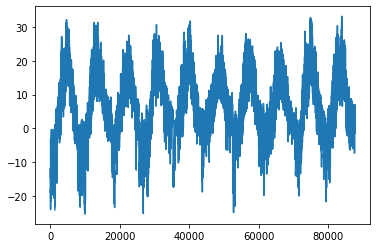

In [6]:
import matplotlib.pyplot as plt
plt.plot(decade_data['Ilman lämpötila (degC)'].values)

Lets check that we actually have wanted date on all field we need

In [7]:
decade_data.count()

Vuosi                          87658
Kk                             87658
Pv                             87658
Klo                            87658
Aikavyöhyke                    87658
Pilvien määrä (1/8)            81804
Ilmanpaine (msl) (hPa)         87638
Suhteellinen kosteus (%)       87636
Sateen intensiteetti (mm/h)    68563
Lumensyvyys (cm)               82779
Ilman lämpötila (degC)         87640
Kastepistelämpötila (degC)     87636
Näkyvyys (m)                   83341
Tuulen suunta (deg)            87634
Puuskanopeus (m/s)             87611
Tuulen nopeus (m/s)            87588
dtype: int64

Here we se that we are missing measurements for some field. Lets drop all the rows that miss values in temperature, pressure, humidity, wind speed or wind direction.

In [8]:
filtered_data = decade_data.dropna(subset=['Ilman lämpötila (degC)','Ilmanpaine (msl) (hPa)','Suhteellinen kosteus (%)','Tuulen suunta (deg)', 'Tuulen nopeus (m/s)' ])

In [9]:
filtered_data.count()

Vuosi                          87582
Kk                             87582
Pv                             87582
Klo                            87582
Aikavyöhyke                    87582
Pilvien määrä (1/8)            81750
Ilmanpaine (msl) (hPa)         87582
Suhteellinen kosteus (%)       87582
Sateen intensiteetti (mm/h)    68511
Lumensyvyys (cm)               82713
Ilman lämpötila (degC)         87582
Kastepistelämpötila (degC)     87582
Näkyvyys (m)                   83285
Tuulen suunta (deg)            87582
Puuskanopeus (m/s)             87582
Tuulen nopeus (m/s)            87582
dtype: int64

we lost bit less than hundread datapoints which is not too bad. ofcourse we might have created some bigger gaps in the data. But in this test we are not going to worry about that.

#### Separate test and train set
To evaluate the quality of our model we should leave some data for evaluateing the model. Lets use the year 2019 for evaluation and 2010-2018 for training it.

In [10]:
test_data = filtered_data.loc[filtered_data['Vuosi'] >= 2019]

In [11]:
train_data = filtered_data.loc[filtered_data['Vuosi'] <=2018]

In [12]:
train_data

,Vuosi,Kk,Pv,Klo,Aikavyöhyke,Pilvien määrä (1/8),Ilmanpaine (msl) (hPa),Suhteellinen kosteus (%),Sateen intensiteetti (mm/h),Lumensyvyys (cm),Ilman lämpötila (degC),Kastepistelämpötila (degC),Näkyvyys (m),Tuulen suunta (deg),Puuskanopeus (m/s),Tuulen nopeus (m/s)
0,2010,1,1,00:00,UTC,NaN,1003.6,87.0,NaN,20.0,-14.6,-16.3,NaN,23.0,3.2,2.2
1,2010,1,1,01:00,UTC,NaN,1004.0,87.0,NaN,20.0,-13.3,-14.9,NaN,40.0,3.3,2.0
2,2010,1,1,02:00,UTC,NaN,1004.1,87.0,NaN,20.0,-12.4,-14.0,NaN,41.0,3.7,1.8
3,2010,1,1,03:00,UTC,NaN,1004.2,87.0,NaN,19.0,-11.8,-13.5,NaN,45.0,5.3,2.4
4,2010,1,1,04:00,UTC,NaN,1004.5,87.0,NaN,20.0,-11.8,-13.4,NaN,47.0,6.4,2.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2018,12,31,19:00,UTC,8.0,1007.0,96.0,1.3,5.0,1.4,0.9,6300.0,190.0,13.5,7.1
8756,2018,12,31,20:00,UTC,8.0,1004.9,98.0,1.6,6.0,1.3,1.0,5190.0,192.0,12.2,6.5
8757,2018,12,31,21:00,UTC,8.0,1002.7,99.0,2.3,6.0,1.4,1.2,5720.0,191.0,9.6,4.8
8758,2018,12,31,22:00,UTC,8.0,1000.4,98.0,0.0,6.0,2.8,2.5,19540.0,211.0,7.8,4.4


#### Normalize data

     |████████████████████████████████| 7.1 MB 2.6 MB/s eta 0:00:01
     |████████████████████████████████| 294 kB 1.3 MB/s eta 0:00:01
     |████████████████████████████████| 26.1 MB 2.1 MB/s eta 0:00:01
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=2397 sha256=d3bd1ba2987085a863cfdb5e926c61ffaa258ad90cfb04083765ce73d0e417b1
  Stored in directory: /root/.cache/pip/wheels/23/9d/42/5ec745cbbb17517000a53cecc49d6a865450d1f5cb16dc8a9c
Successfully built sklearn


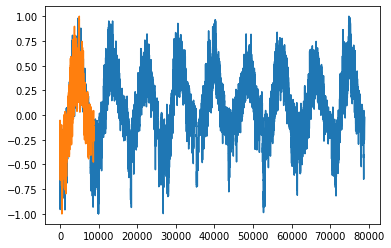

In [13]:
try:
    from sklearn.preprocessing import MinMaxScaler
except ModuleNotFoundError:
    !pip install sklearn
    from sklearn.preprocessing import MinMaxScaler

    
temperature_train = train_data['Ilman lämpötila (degC)'].values
temperature_test =test_data['Ilman lämpötila (degC)'].values

temperature_scaler = MinMaxScaler([-1,1])
scaled_temperature = temperature_scaler.fit_transform(temperature_train.reshape([-1,1]))
scaled_temperature_test = temperature_scaler.fit_transform(temperature_test.reshape([-1,1])) 
plt.plot(scaled_temperature)
plt.plot(scaled_temperature_test)

## Single variate prediction with LSTM
LSTM, Long short term memory is a special kind of a recurrent neural network layer were the data of past data point is given preserved for future points to use. Thus it is usefull for predicting time series.

[inset a picture here]

### Shape data for prediction
For time series prediction we are going to shape the data into sets with shape (variables,prediction_history,number_variables)

In [14]:
import numpy as np
def data_to_training(data, len_hist, len_pred):
    value = []
    pred_value = []
    start = len_hist
    stop = len(data)-len_pred
    for i_start in range(start,stop):
        index_hist = range(i_start-len_hist,i_start)
        index_pred = range(i_start,i_start+len_pred)
        #reshape the values to (number_of_datapoint, varibles).
        value.append(np.reshape(data[index_hist],(len_hist,1)))
        pred_value.append(data[index_pred])
    return np.array(value), np.array(pred_value)

In [66]:
train_values,train_preds = data_to_training(scaled_temperature,240,120)
test_values, test_preds = data_to_training(scaled_temperature_test, 240, 120)

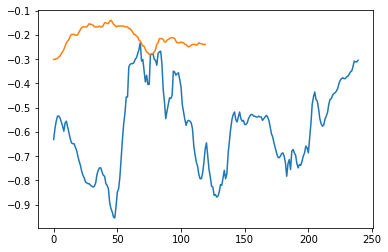

In [67]:
plt.plot(train_values[0])
plt.plot(train_preds[0])

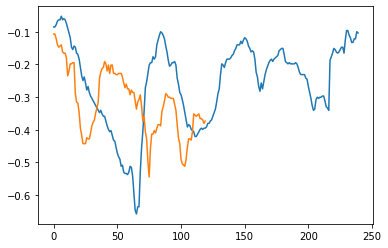

In [68]:
plt.plot(test_values[0])
plt.plot(test_preds[0])

To make the data suitable for out neural network to read we shall use `tensorflow`'s dataset tool that turns out tensor data into slices along the first axis. Lets import tensorflow.

In [69]:
import tensorflow as tf

Use tensorflow `Dataset.from_tensor_slices` makes slices out of the data we are using. Then for FOR SOME REASON we chacke the data set. Cache makes data faster to read?

In [70]:
BATCH_SIZE = 120
BUFFER_SIZE = 10000

train_input = tf.data.Dataset.from_tensor_slices((train_values, train_preds))
train_input = train_input.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

test_input = tf.data.Dataset.from_tensor_slices((test_values, test_preds))
test_input = test_input.batch(BATCH_SIZE).repeat()


#### A very simple LSTM for predictin

For simplisity we make the model using keras framework to handle the powers of tensorflow.

In [71]:
LSTM_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, input_shape = train_values.shape[-2:], return_sequences=True),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(1)
])

Then we have to choose the optimizer and loss funtion for out model and  compile it

In [72]:
LSTM_model.compile(optimizer='adam', loss='mae')

Then we fit our model with the data we have

In [73]:
EVALUATION_INTERVAL = 150
EPOCHS = 4

LSTM_model.fit(train_input, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=test_input, validation_steps=50)

Train for 150 steps, validate for 50 steps
Epoch 1/4
150/150 [==============================] - 27s 181ms/step - loss: 0.1326 - val_loss: 0.1400
Epoch 2/4
150/150 [==============================] - 30s 197ms/step - loss: 0.1180 - val_loss: 0.1414
Epoch 3/4
150/150 [==============================] - 30s 202ms/step - loss: 0.1115 - val_loss: 0.1417
Epoch 4/4
150/150 [==============================] - 29s 192ms/step - loss: 0.1129 - val_loss: 0.1398


In [74]:
LSTM_model.predict(np.reshape(test_values[0],(1,-1,1)))

array([[-0.1349221]], dtype=float32)

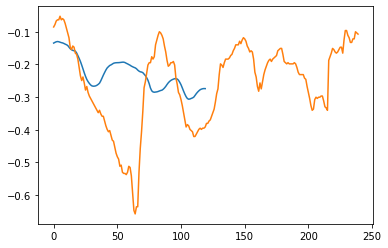

In [75]:
for x, y in test_input.take(1):
    #print (LSTM_model.predict(x))
    #print (y[1])
    plt.plot(LSTM_model.predict(x))
    plt.plot(x[1])
    plt.show()
    

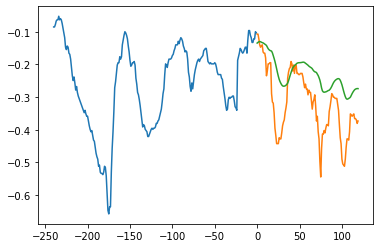

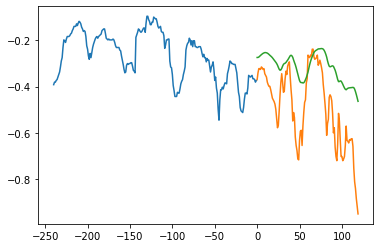

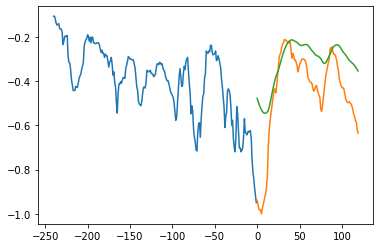

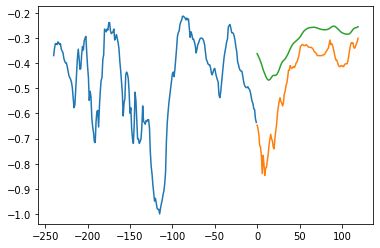

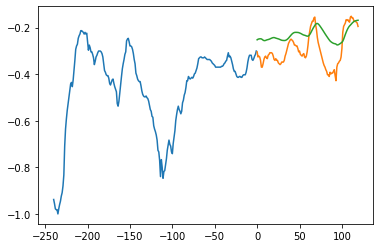

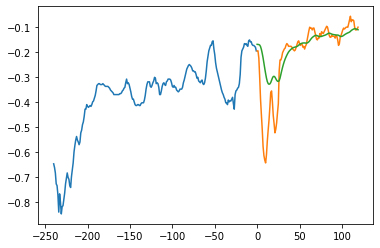

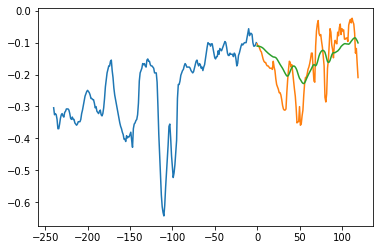

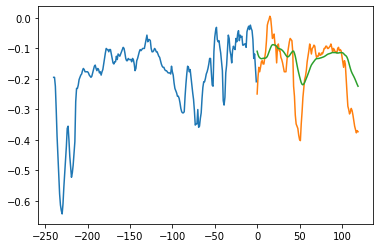

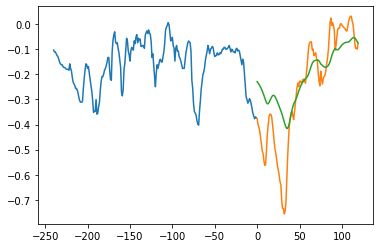

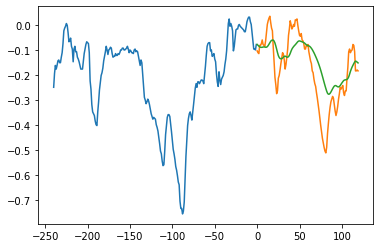

In [76]:
for x,y in test_input.take(10):
  plt.plot(range(-len(x[0]),0),x[0])
  plt.plot(range(0, len(y[0])), y[0])
  pred = LSTM_model.predict(x)
  #print(pred)
  plt.plot(range(0,len(pred)), pred)
  plt.show()

The predictions have many correct features but are far from perfect. But for this test this is totally fine. Next step is to find out how we are going to add more variables to our prediction. 

## Multivariate predictions
Using multiple variables will propably require a bit more complex network, but could make the predictions better and of when we speak about for example the weather the temperature is not the only thing that matters. Humidity and windspeed can have big effect on how warm the weather feels.

Lets take wind direction as our second variable

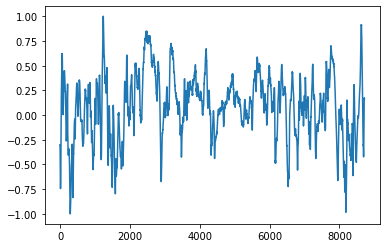

In [103]:
wind_direction_train = train_data['Tuulen suunta (deg)'].values
wind_direction_test =test_data['Ilmanpaine (msl) (hPa)'].values

wind_dir_scaler = MinMaxScaler([-1,1])
scaled_wind_dir = wind_dir_scaler.fit_transform(wind_direction_train.reshape([-1,1]))
scaled_wind_dir_test = wind_dir_scaler.fit_transform(wind_direction_test.reshape([-1,1])) 
#plt.plot(scaled_wind_dir)
plt.plot(scaled_wind_dir_test)

In [104]:
def multi_data_to_training(data, len_hist, len_pred):
    value = []
    pred_value = []
    current_data = []
    start = len_hist
    stop = len(data[0])-len_pred
    print(range(start,stop))
    for i_start in range(start,stop):
        index_hist = range(i_start-len_hist,i_start)
        index_pred = range(i_start,i_start+len_pred)
        #reshape the values to (number_of_datapoint, varibles).
        current_data = np.reshape(data[0][index_hist],(len_hist,1))
        pred_data = np.reshape(data[0][index_pred],(len_pred,1))
        for val in data[1:]:
            current_data = np.concatenate(
                (current_data,np.reshape(val[index_hist],(len_hist,1))),
                axis=1
            )
            
            pred_data = np.concatenate(
                (pred_data, np.reshape(val[index_pred],(len_pred,1))),
                axis=1
            )
        value.append(current_data)
        pred_value.append(pred_data)
    return np.array(value), np.array(pred_value)

In [105]:
wind_direction_train.shape

(78867,)

In [106]:
train_values, train_preds = multi_data_to_training([scaled_temperature,scaled_wind_dir],256,128)
test_values, test_preds = multi_data_to_training([scaled_temperature_test,scaled_wind_dir_test],256,128)

range(256, 78739)
range(256, 8587)


In [107]:
print(train_preds.shape)
print(train_values.shape)

(78483, 128, 2)
(78483, 256, 2)


In [108]:
BATCH_SIZE = 128
BUFFER_SIZE = 10000

train_input = tf.data.Dataset.from_tensor_slices((train_values, train_preds))
train_input = train_input.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

test_input = tf.data.Dataset.from_tensor_slices((test_values, test_preds))
test_input = test_input.batch(BATCH_SIZE).repeat()

In [109]:
LSTM_model2 = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, input_shape = train_values.shape[-2:], return_sequences=True),
    tf.keras.layers.LSTM(16, activation='relu'),
    tf.keras.layers.Dense(2)
])

In [110]:
LSTM_model2.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

In [125]:
EVALUATION_INTERVAL = 10
EPOCHS = 15

train_hist = LSTM_model2.fit(train_input, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=test_input, validation_steps=25)

Train for 10 steps, validate for 25 steps
Epoch 1/15
10/10 [==============================] - 2s 249ms/step - loss: 0.3996 - val_loss: 0.2717
Epoch 2/15
10/10 [==============================] - 2s 232ms/step - loss: 0.3949 - val_loss: 0.2806
Epoch 3/15
10/10 [==============================] - 2s 238ms/step - loss: 0.3964 - val_loss: 0.3022
Epoch 4/15
10/10 [==============================] - 2s 227ms/step - loss: 0.3982 - val_loss: 0.3157
Epoch 5/15
10/10 [==============================] - 2s 228ms/step - loss: 0.3894 - val_loss: 0.3143
Epoch 6/15
10/10 [==============================] - 3s 264ms/step - loss: 0.3749 - val_loss: 0.2971
Epoch 7/15
10/10 [==============================] - 3s 292ms/step - loss: 0.3873 - val_loss: 0.2899
Epoch 8/15
10/10 [==============================] - 3s 289ms/step - loss: 0.3734 - val_loss: 0.2778
Epoch 9/15
10/10 [==============================] - 3s 297ms/step - loss: 0.3630 - val_loss: 0.2826
Epoch 10/15
10/10 [==============================] - 3s 29

[0.00749547 0.00748959 0.00727023 0.00713637 0.00719262 0.00738919
 0.00772921 0.00807968 0.00838984 0.00857032 0.00860977 0.00846524
 0.00824102 0.00798465 0.00767617 0.00730695 0.00692962 0.00659967
 0.00629639 0.00603352 0.00580563 0.00545217 0.00509764 0.00484562
 0.00475173 0.00478116 0.00496743 0.00534231 0.00575731 0.00626842
 0.00674353 0.00718188 0.00766716 0.00814638 0.00859992 0.00901895
 0.00938872 0.00971892 0.00994038 0.01011797 0.01029263 0.01044405
 0.01049062 0.01052638 0.01052544 0.01053347 0.01047664 0.01038737
 0.01029315 0.01028139 0.01038945 0.01039894 0.01028638 0.01005577
 0.00989675 0.00992907 0.00994898 0.01008294 0.0102777  0.0106673
 0.01118184 0.01125057 0.01087888 0.01032268 0.00969081 0.00912431
 0.00859309 0.00811067 0.0077047  0.00738354 0.00699224 0.00658926
 0.00620865 0.00585111 0.00560233 0.0054908  0.00547394 0.00552711
 0.0056197  0.00573562 0.00590635 0.00612662 0.0064678  0.00690769
 0.0073472  0.00782318 0.00822514 0.00847377 0.00856151 0.00842

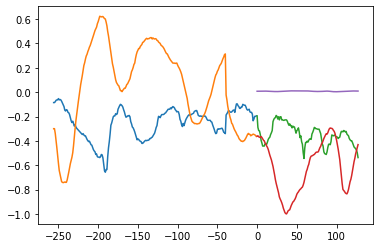

[0.00891344 0.00899938 0.00899714 0.00866876 0.00798476 0.00707455
 0.00613751 0.00549131 0.00515268 0.00498802 0.00473648 0.00435622
 0.00398982 0.00367647 0.00355791 0.00354342 0.00342105 0.00317907
 0.00328393 0.00379057 0.00411389 0.00426119 0.00454999 0.00489855
 0.00517133 0.00538146 0.00540249 0.00485004 0.00417793 0.00380248
 0.00346781 0.00333991 0.00339982 0.00357314 0.00376993 0.0040487
 0.00433627 0.00471674 0.00505049 0.005308   0.00552352 0.00570286
 0.00590076 0.00609785 0.00625574 0.00637612 0.00649795 0.00662886
 0.00677344 0.00686122 0.0069423  0.00704118 0.00709716 0.00709282
 0.00703329 0.0069119  0.00676491 0.00660525 0.00643642 0.00620439
 0.00608157 0.00606132 0.00622068 0.00642323 0.00658886 0.00668426
 0.00667502 0.00652832 0.00638669 0.00618298 0.00593598 0.00570173
 0.00561739 0.00578794 0.00597443 0.00602769 0.00592739 0.00578463
 0.00563269 0.0055043  0.00541692 0.00542143 0.00556694 0.0056684
 0.00573068 0.00576913 0.00582161 0.00587902 0.00594604 0.006020

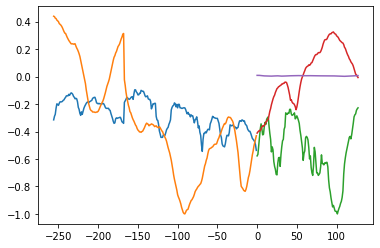

In [126]:
for x,y in test_input.take(2):
  plt.plot(range(-len(x[0]),0),x[0])
  plt.plot(range(0, len(y[0])), y[0])
  pred = LSTM_model2.predict(x)
  print(pred[:,0])
  plt.plot(range(0,len(pred)), pred[:,0])
  plt.show()

In [127]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

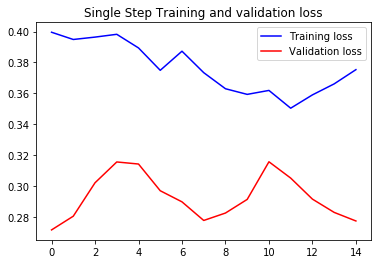

In [128]:
plot_train_history(train_hist,
                   'Single Step Training and validation loss')